# Simple Neural Network Using Tensorflow

<img src="res/tf.jpg">

we use tensorflow to classify the [MNIST](https://keras.io/datasets/) dataset

# The initial setup, imports and install 

In [1]:
! pip install seaborn
! pip install pylab
! pip install keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import tensorflow as tf 
from tensorflow.python.framework import ops
tf.reset_default_graph()

# some styling
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)


  Could not find a version that satisfies the requirement pylab (from versions: )
No matching distribution found for pylab


Using TensorFlow backend.


(50000, 28, 28) (50000,)


# Data Exploration

## let's take a look at the data histogram

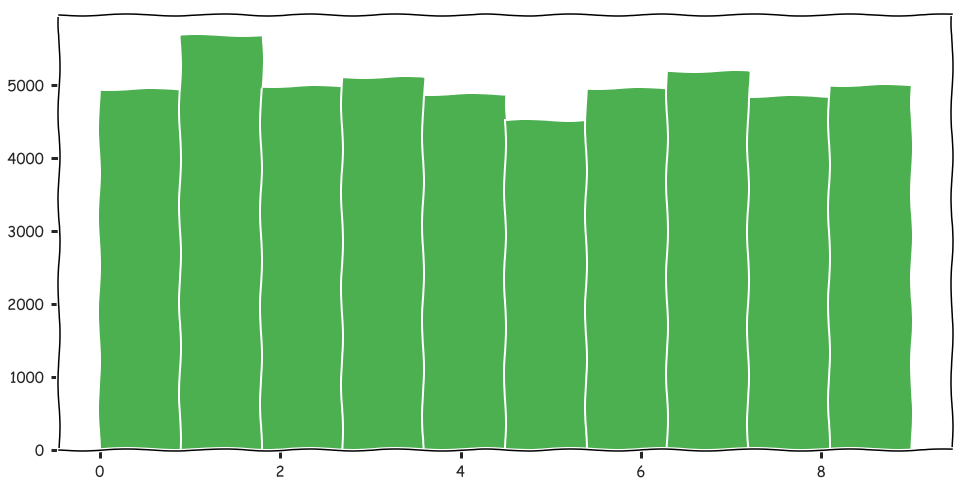

In [2]:
plt.hist(y_train, 10)
plt.show()

## So the data is equally distributed, that's good

## a random sample of the data

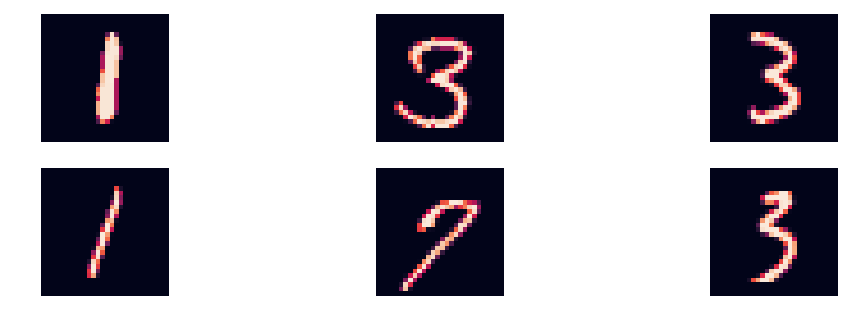

In [3]:
randoms = np.random.randint(0, X_train.shape[0], 6)

for idx, val in enumerate(randoms):
    plt.subplot(int(len(randoms)/2), int(len(randoms)/2), idx+1)
    plt.axis('off')
    plt.imshow(X_train[val])
    plt.subplots_adjust(wspace=0.5)
    
plt.show()

## A better histogram

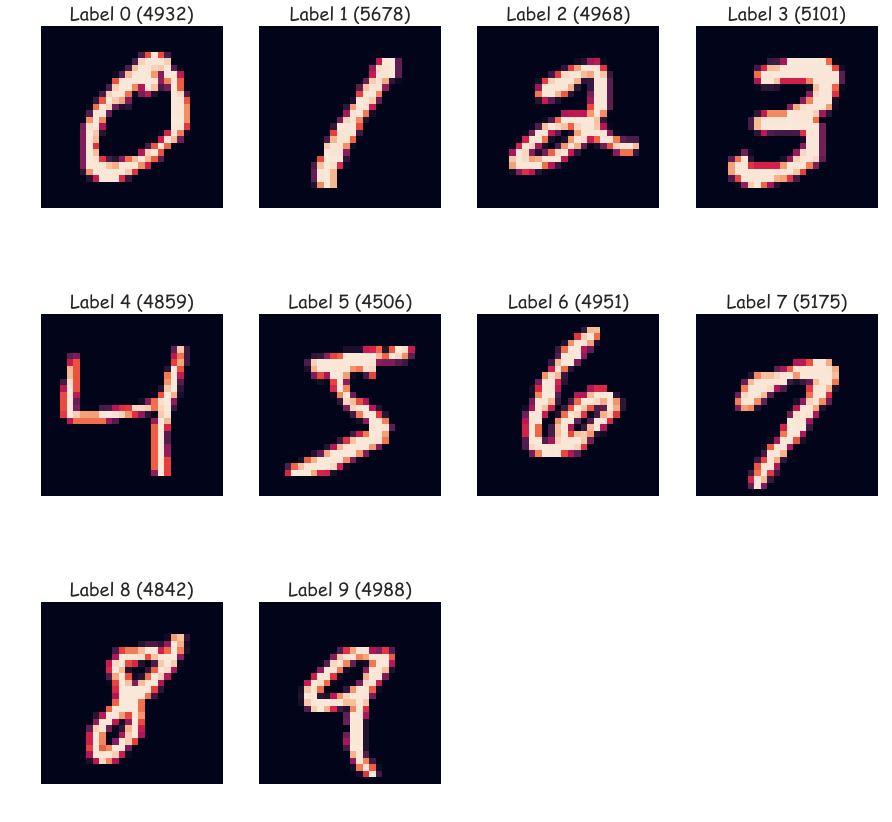

In [4]:
# Get the unique labels 
unique_labels = set(y_train)

# Initialize the figure
plt.figure(figsize=(15, 15))

# For each unique label,
for idx, label in enumerate(unique_labels):
    # You pick the first image for each label
    image = X_train[np.where(y_train==label)][0]
    # Define 3x4 subplots 
    plt.subplot(3, 4, idx+1)
    # Don't include axes
    plt.axis('off')
    # Add a title to each subplot 
    plt.title("Label {0} ({1})".format(label, np.count_nonzero(y_train==label)))
    # And you plot this first image 
    plt.imshow(image)
    
# Show the plot
plt.show()

## Now we see a fair sample of the data and the size of each class

# Let's build the network !

NOTE: most of the code i already built in the Andrew NG course

## Preparing the inputs for the model

### A one hot encoder is usually used to represent the multi-labeled classes
### Example: 

X : [...], y : 2    ==> y : 0 0 1<br>
X : [...], y : 1    ==> y : 0 1 0<br>
x : [...], y : 0    ==> y : 1 0 0<br>


In [5]:
def one_hot_matrix(labels, n_classes):
    depth = tf.constant(n_classes, name = "C")
    one_hot_matrix = tf.one_hot(labels, depth, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

### A shortcut for the place holder builder
it expect the inputs to be 1D though, for example the input could be [1, 2, 3, 5, ....] for one instance, and could be of whatever length, that's why we used [n_x, None], the n_x: represents the length of the input, the None: represents that there could be multiple instaces
### that's actually perfect for our model !, the outputs are 1D (thanks to the 1hot encoder we did in the upper cell) but the input is still a 2D matrix :/, but we gonna solve this in a bit...

In [6]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    return X, Y

## Initializing the model params
our model will have 1 hidden layer, so we will need (W1, b1) for the weights of the input to the layer, (W2, b2) for the layer to output layer weights.
### A perfect usecase for the Tensorflow variables !
we use tensorflow variables here as they allow the variables to be changed in the time of training, and that's exactly what we need for our model to learn and build his weights
### The shapes of the Weights ??
i used 50 nodes to represents the data, actually this number can change, you simply try a reasonable number and give your model a try, then iterate till you find a good number :D <br>
so the numbers :
* 50x784 >> 50 for the number of nodes, 784 for the flattened image (28x28), this is the input layer
* 50x1 >> the bais vector, 50 for the number of nodes of course, 1 because it is 1D
* 10x50 >> 10 because the hidden layer is connected to a 10 nodes (the output nodes) which are actually just the 1hot encoder representation of the output, 50 because there're 50 nodes in the hidden layer
* 10x1 >> the bias vector of the last layer (hidden to output)

In [7]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [50,784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [50,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [10, 50], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [10,1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

### Forward Propagation
this is the basic operation of any learning model.<br>
### That's when we use Tensorflow basic operations !
the basic operations like add, subtract or multiply are implemented in tensorflow in two ways
* tf.add(tensor1, tensor2)
* tensor1 * tensor2

you could choose whatever you like, they are the same.
### what happens here ?
it apply the weights it learned so far on the input vector<br>
you can see the sequnce here, first apply the first equation: 
* (W1 * X) + b1 -> Z1

that will produce the output of input layer to the hidden one, but notice that this is a linear function, and it can't capture enough info about the data given, so we apply an activation function
* A1 = relu(Z1)

> note that tensorflow has the reul already implemented in it using ```tf.nn.relu(tensor)```

then we apply the weights from the hidden layer to the output layer
* (W2 * A1) + b2 -> Z2

NOTE : based on the training data, the model will output score for each class (the 1hot encoded featuers) and we will be taking the max of these scores

In [8]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)    
    return Z2

### The cost of our model so far
after we train a model and make some predictions, we need to check the cost/losses of it<br>
* the logits are simply the output of the prev function, they are scores per label (remember these are 1hot encoded)<br>
* the labels are the true labels of our data<br>

we use here the ```tf.reduce_mean()``` as it's functionality is to Computes the mean of elements across dimensions of a tensor.<br>
so we use it to calculate the mean over our loss function here which is ```softmax_cross_entropy_with_logits``` which is used with the multi-label classification, and luckely it is implemented in tensorflow ```tf.nn.softmax_cross_entropy_with_logits```


In [9]:
def compute_cost(Z2, Y):
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))    
    return cost

### split our data into some small batches
nothing very special here, we just split our data and get a shuffled mini batch to train our model on

In [10]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### THE BIG ONE, THE MODEL ITSELF
actually the model itself, we already built most of it, the least thing to do is to links all these things together.<br>
the cell is reasonably commented at almost each step
but let's have a qucik look at what the model does :
* first will do forward prob
* calculate the cost for the weights we got
* Optimize the weigts based on the cost we had 

### Useful notes
* to get the output of a given tensor (let's say you want to get just the forward prob, not the whole graph), you need to run that given tensor and pass it the variables using the following 
    ```
    with tf.Session() as sess:
        output = sess.run([THE_TENSOR], feed_dict={VAR_NAME: VALUE})

    ```

* you should always keep track of the loss function over the time, you might see that the loss already coverged and more epochs would be useless



In [11]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
    
    # initial setup
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                            
    costs = []                                        
    
    # building the graph blocks
    
    # get the placeholdes for your graph ready and initialize the parameters
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    
    # get the logits 
    Z2 = forward_propagation(X, parameters)
    
    # the cost calculation, notice that it takes the logits and the true labels
    cost = compute_cost(Z2, Y)
    
    # the OPTIMIZER which reduce the cost function, to increase the model accuracy
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # this is important in any tensorflow graph, you initialize everything
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization    
        sess.run(init)
        
        # loop through the epochs
        for epoch in range(num_epochs):
            """
            here we initialize the cost by zero
            get the number of mini batches, by dividing the training data by the size of the batch
            loop through each batch
                run the tensorflow session (which will run the graph we defined up there)
                the graph will calculate the logits and the cost then optimize it using the given optimzer
                we will then print the epoch cost only when we reach a epoch that is divisable by 10
            """
            epoch_cost = 0.                         
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                epoch_cost += minibatch_cost / num_minibatches
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

                plt.plot(np.squeeze(costs))
                
                
        """
        in here we plot the cost over iterations,
        we optain the params then evaluate the model
        notice that in order to get an output of a certain tensor you need to run it using tf.sess.run
        """
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Validation Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))

        return parameters

## We told the net that it gonna get a 1D array :/
not a problem actually, we need to transform our input array into 1D, and it's fairly simple using numpy.<br>
notice that we used the `T` to get the transpose of the output, as it's gonna be 1 row per instance and we need it to be 1 col per instance<br>
## Time to train it ...

Cost after epoch 0: 0.858143
Cost after epoch 10: 0.174087
Cost after epoch 20: 0.118108
Cost after epoch 30: 0.088499
Cost after epoch 40: 0.069406
Cost after epoch 50: 0.055942
Cost after epoch 60: 0.045671
Cost after epoch 70: 0.037601
Cost after epoch 80: 0.031245
Cost after epoch 90: 0.025733
Cost after epoch 100: 0.021193


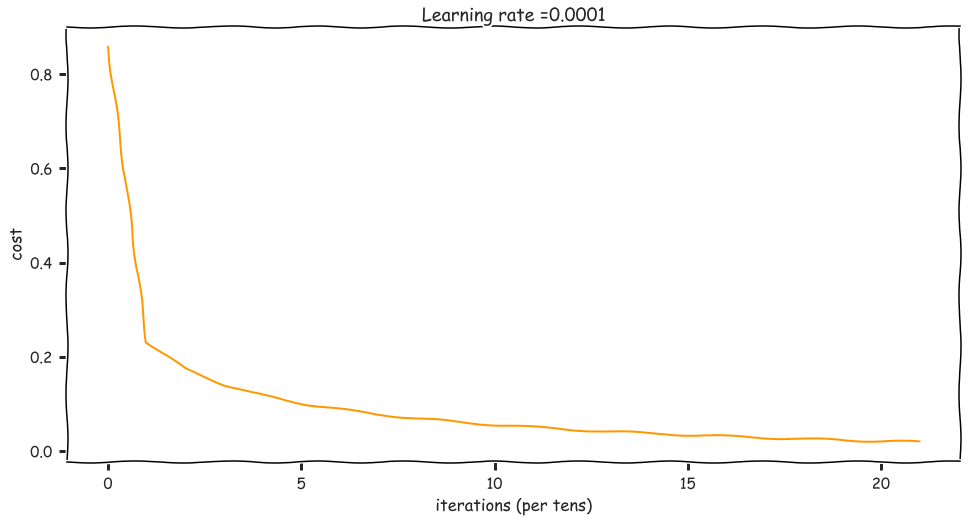

Parameters have been trained!
Train Accuracy: 0.99774
Validation Accuracy: 0.9716


In [12]:
# Reshape the training, validate and test examples as the 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

y_train_one_hot = one_hot_matrix(y_train, 10)
y_val_one_hot = one_hot_matrix(y_val, 10)
y_test_one_hot = one_hot_matrix(y_test, 10)


parameters = model(X_train_flatten, y_train_one_hot, X_val_flatten, y_val_one_hot, num_epochs=110, print_cost=True)

## we can see that the cost function actually didn't make that much of improvement after the ~ 40 epoch, we can try again with 40 epochs

Cost after epoch 0: 0.858143
Cost after epoch 10: 0.174087
Cost after epoch 20: 0.118108
Cost after epoch 30: 0.088499


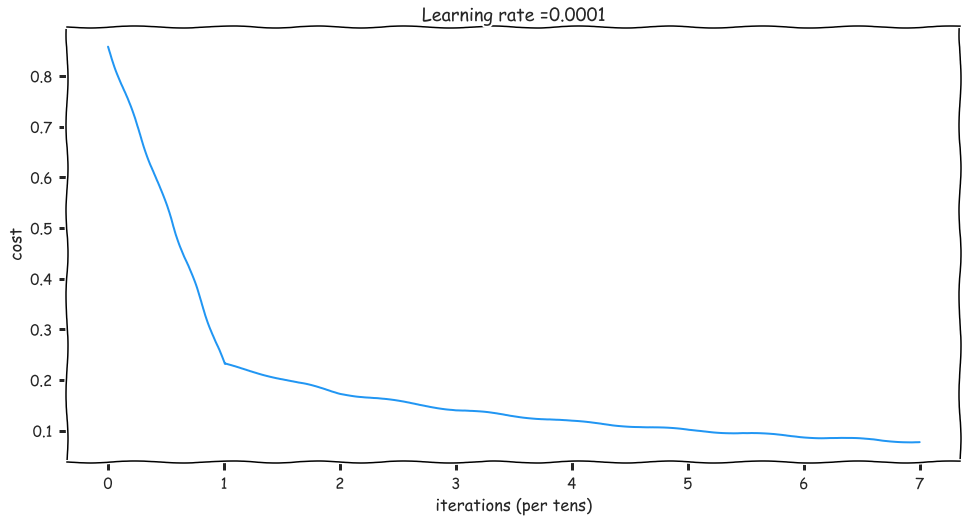

Parameters have been trained!
Train Accuracy: 0.98186
Validation Accuracy: 0.9695


In [13]:
params = model(X_train_flatten, y_train_one_hot, X_val_flatten, y_val_one_hot, num_epochs=40, print_cost=True)

## Test Accuarcy 
here we test the accuarcy of our learned params (which are the model actually) on the test set
### NOTES: 
* here we the forward prob tensor, then we evaluate the predictions by generating a bool array of the correct predictions using ```tf.equal```<br>
* the accuarcy is a mean of the float array generated from the correct pred tensor

In [14]:
n_x = 784                          # the input size of the image
n_y = 10                           # the length of the output
X, Y = create_placeholders(n_x, n_y)
Z2 = forward_propagation(X, parameters)
# Calculate the correct predictions
correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))
# Calculate accuracy on the test set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


with tf.Session() as sess:
    print ("Test Accuracy:", accuracy.eval(feed_dict={X: X_test_flatten, Y: y_test_one_hot}, session=sess))


    
    
print("\n\n\n")    
# FOR UNDERSTADING PURPOSES
# the output of correct pred tensor
with tf.Session() as sess:
    res = correct_prediction.eval(feed_dict={X: X_test_flatten, Y: y_test_one_hot}, session=sess)
    print(res)
# getting the mean will produce the score 
print(np.mean(np.array(res, dtype='f')))     # this is the same as accuracy tensor actually

Test Accuracy: 0.9735




[ True  True  True ...,  True  True  True]
0.9735


## Let's take a better look at the classifeir :D 
here we choose randomly 10 images and see how our model will do on them

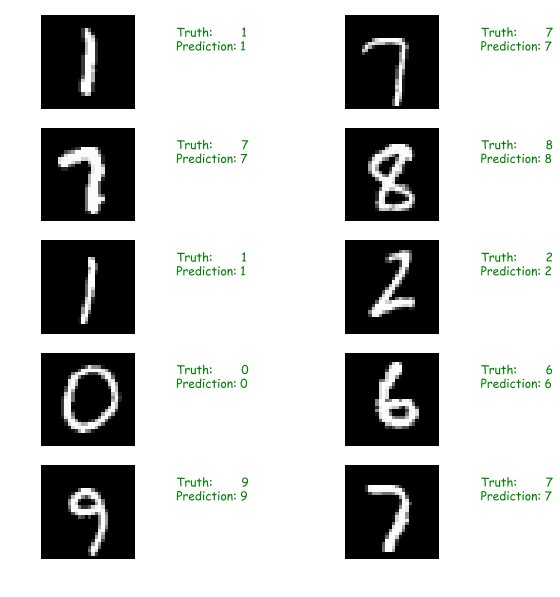

In [15]:
# Pick 10 random images
sample_indexes = np.random.randint(0, X_test_flatten.shape[0], 10)

# these are for the model
sample_images = [X_test_flatten[:, i] for i in sample_indexes]
sample_labels = [y_test_one_hot[:, i] for i in sample_indexes]

# so we can draw them
true_labels = [y_test[i] for i in sample_indexes]
true_images = [X_test[i] for i in sample_indexes]

# inits, we did them a lot at this notebook :D
predicted = None
n_x = 784
n_y = 10
X, Y = create_placeholders(n_x, n_y)
Z2 = forward_propagation(X, parameters)
correct_pred = tf.argmax(Z2)

# get the array in shape for the model, the itterative list up there changed it's nature
arr = np.array(sample_images).T

# generate predictions
with tf.Session() as sess:
    predicted = sess.run([correct_pred], feed_dict={X: arr})[0]

    
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(true_images)):
    truth = true_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(true_images[i],  cmap="gray")

plt.show()

# Resources and references used

[TensorFlow Tutorial For Beginners](https://www.datacamp.com/community/tutorials/tensorflow-tutorial)<br>
[TensorFlow Examples](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py)<br>
[Building a Simple Neural Network — TensorFlow for Hackers (Part II)](https://medium.com/@curiousily/tensorflow-for-hackers-part-ii-building-simple-neural-network-2d6779d2f91b)<br>
[tf_api_docs](https://www.tensorflow.org/api_docs/)<br>
[An Introduction to Implementing Neural Networks using TensorFlow](https://www.analyticsvidhya.com/blog/2016/10/an-introduction-to-implementing-neural-networks-using-tensorflow/)<br>